# **Sesión 11 : Segmentación de Objetos**


<a id='setup'></a>
## 1· Setup – instalación , la GPU no es necesaria ya que haremos solo inferencia (pero puedes activarla si deseas)

In [ ]:
!pip -q install ultralytics

import torch, torchvision, cv2, numpy as np, matplotlib.pyplot as plt
print(f'Torch {torch.__version__} · TorchVision {torchvision.__version__} · CUDA disponible: {torch.cuda.is_available()}')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00
Torch 2.6.0+cu124 · TorchVision 0.21.0+cu124 · CUDA disponible: False


<a id='conceptos'></a>
## 2· Conceptos clave de segmentación
- **Semantic segmentation:** asigna una etiqueta por píxel, sin distinguir instancias.
- **Instance segmentation:** segmenta objetos individuales además de su clase.

**Métricas** más usadas:

- *IoU (Intersection‑over‑Union)* por máscara.
- *Dice coefficient* (F1 de área superpuesta).
- *AP<sub>mask</sub>*: área bajo la curva de precisión‑recall con umbral en IoU.


<a id='maskrcnn'></a>
## 3· Usando Mask R‑CNN (`torchvision`)
Mask R‑CNN extiende Faster R‑CNN añadiendo un cabezal de máscara. El modelo pre‑entrenado sobre COCO está disponible en `torchvision.models.detection`.

Descarga el modelo y obtenemos los nombres de las clases

In [ ]:
from torchvision import transforms
from PIL import Image
from torchvision.models.detection import (
        maskrcnn_resnet50_fpn,
        MaskRCNN_ResNet50_FPN_Weights,
        MaskRCNN_ResNet50_FPN_V2_Weights)

# Cargamos modelo pre‑entrenado (COCO 91 clases)
weights     = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT  # = COCO
class_names = weights.meta["categories"]
mask_model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
mask_model.eval()
mask_model.cuda() if torch.cuda.is_available() else None

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 147MB/s]


La siguiente función segmenta una imagen usando MASK R-CNN, devolviendo la máscara compuesta sobre la imagen original.

In [ ]:
# Paleta de colores fija para instancias
import random
from matplotlib.patches import Patch

random.seed(60)
_COLORS = np.random.randint(0, 255, size=(100, 3), dtype=np.uint8)

def segment_maskrcnn(img_path, score_th=0.5):
    img = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    tensor = transform(img)[None]
    if torch.cuda.is_available():
        tensor = tensor.cuda()
        mask_model.cuda()
    with torch.no_grad():
        out = mask_model(tensor)[0]
    # Filtramos por score
    keep = out['scores'] > score_th
    masks = (out['masks'][keep] > 0.5).squeeze(1).cpu().numpy()
    labels = out['labels'][keep].cpu().numpy()
    # Superponer
    img_np = np.array(img)
    legend = {}
    for m, lab in zip(masks, labels):
        # print(class_names[lab])
        color = _COLORS[lab % 100].tolist()
        img_np[m] = img_np[m]*0.3 + np.array(color)*0.7
        legend[lab] = color
    plt.figure(figsize=(8,8))
    plt.imshow(img_np.astype(np.uint8))
    plt.axis('off')
    plt.title("Mask R-CNN")

    # --- construir la leyenda -------------------------------------------------
    handles = [
        Patch(
            facecolor=np.array(c)/255.0,      # normalizado 0-1
            edgecolor='black',
            label=class_names[l]
        )
        for l, c in legend.items()
    ]
    if handles:                               # solo si hay algo que mostrar
        plt.legend(
            handles=handles,
            bbox_to_anchor=(1.02, 1),         # fuera del eje
            loc='upper left',
            borderaxespad=0.0,
            frameon=True
        )

    plt.tight_layout()
    plt.show()


Prueba con tu propia imagen

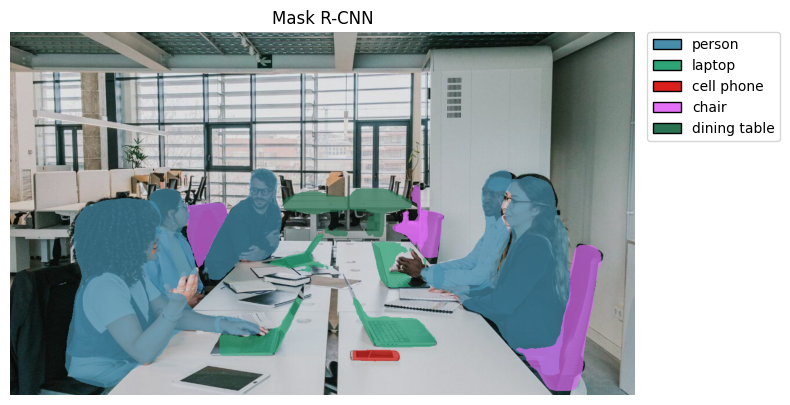

In [ ]:
import urllib.request, os, shutil
img_path = "imagen2.jpg"
# url = "https://ultralytics.com/images/bus.jpg"
segment_maskrcnn(img_path, score_th=0.8)


<a id='yolov8'></a>
## 4· Usando YOLOv8-Seg (Ultralytics)
YOLOv8 incluye una cabeza de segmentación que produce máscaras basadas en prototipos.

In [ ]:
from ultralytics import YOLO

yolo_model = YOLO("yolov8m-seg.pt")  # modelo liviano pre‑entrenado COCO

def segment_yolo(img_path):
    results = yolo_model.predict(img_path, save=False, conf=0.25)
    res = results[0]
    # Visualización
    # res.show()  # Abre ventana interactiva en Colab (HTML)
    img_bgr = res.plot(
        boxes=True,          # oculta cajas
        masks=True,           # mantiene máscaras
        labels=True,           # texto on/off
        # box_kwargs={"lw": 0}
    )
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # Para dibujar aquí:
    plt.figure(figsize=(8,8))
    plt.imshow(img_rgb)  # result.plot() devuelve np.ndarray BGR
    plt.axis('off')
    plt.title("YOLOv8-Seg")

100%|██████████| 52.4M/52.4M [00:00<00:00, 132MB/s]


Ahora probemos el mismo ejemplo:


image 1/1 /content/imagen2.jpg: 384x640 5 persons, 5 chairs, 1 dining table, 4 laptops, 314.3ms
Speed: 6.1ms preprocess, 314.3ms inference, 48.0ms postprocess per image at shape (1, 3, 384, 640)


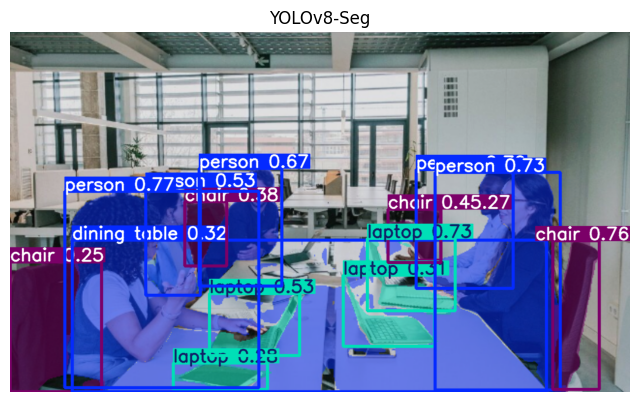

In [ ]:
segment_yolo(img_path)

<a id='comparacion'></a>
## 5· Comparación rápida de FPS
Este fragmento mide el tiempo medio de inferencia una sola imagen para cada modelo (sin incluir pre‑proceso).

In [ ]:
import time, contextlib

def time_it(fn, n=20):
    start = time.time()
    for _ in range(n):
        fn(img_path)
    return (time.time() - start)/n

fps_mask = 1 / time_it(lambda p: mask_model([transforms.ToTensor()(Image.open(p)).cuda() if torch.cuda.is_available() else transforms.ToTensor()(Image.open(p)) ])[0], n=10)
fps_yolo = 1 / time_it(lambda p: yolo_model.predict(p, save=False, verbose=False), n=10)

print(f"Mask R‑CNN ≈ {fps_mask:.2f} FPS")
print(f"YOLOv8‑Seg ≈ {fps_yolo:.2f} FPS")


Mask R‑CNN ≈ 0.07 FPS
YOLOv8‑Seg ≈ 4.05 FPS
